# Task 1: Problem Description and Initial Data Analysis

In [14]:
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### Problem Statement

**Real-World Applications & Stakeholder Impact**

This model transforms technical pricing data into actionable market intelligence, enabling specific decisions for key stakeholders:

* **Hosts:** By analyzing **SHAP values** (feature importance), hosts can calculate the ROI of specific renovations (e.g., adding air conditioning) and use demand trends to dynamically calibrate prices for events like the Australian Open.
* **Airbnb Platform:** The platform can use **residual analysis** (the gap between actual and predicted price) to flag potential price-gouging or suggest price reductions for stagnant listings, improving market liquidity.
* **Travelers:** Guests gain transparency by identifying **undervalued listings**—properties where the actual price is lower than the model’s predicted value—helping them secure objective bargains.
* **Investors:** Property managers can leverage **geospatial clustering** to identify suburbs where predicted rental yields are disproportionately high compared to acquisition costs.
* **Government:** Regulators can aggregate model predictions to monitor housing affordability trends and use revenue benchmarks to audit tax compliance by identifying under-reported income.


### Methodology (Evaluation Criteria)
The accuracy of the forecasting models is evaluated by the Mean Absolute Error (MAE). MAE is a metrics to evaluate the accuracy of predictions by calculating the average absolute difference between the accuracy of predictions between predicted and actual prices. Here is the formula:
$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} \left| y_i - \hat{y}_i \right|
$$

Where:
- $y_i$ is the actual price
- $\hat{y}_i$ is the predicted price
- $n$ is the total number of observations<br>
**Advantage:**
- Due to its linear treatment, MAE is less sensitive to outliners than MSE  <br>
**Disadvantages:**
- MAE treats all errors equally and does not reveal if predictions too high or low between overprediction and underprediction <br>
MAE’s simplicity and dollar-denominated clarity make it suitable for Airbnb pricing, where over- and underpricing risks are treated as symmetric.

## Categorize variables


| Variable Kind | Feature Names | Description & Typical Handling |
| :--- | :--- | :--- |
| **Numeric** (Continuous & Discrete) | `accommodates`, `bathrooms`, `bedrooms`, `beds`, `minimum_nights`, `maximum_nights`, `availability_30`, `availability_60`, `availability_90`, `availability_365`, `number_of_reviews`, `reviews_per_month`, `price`, `latitude`, `longitude`, `review_scores_rating` (and other review scores), `host_listings_count`, `calculated_host_listings_count`... | Quantitative data used directly in regression or clustering. |
| **Ordinal** | `host_response_time`, `host_response_rate`*, `host_acceptance_rate`* | Categorical data with a clear order (e.g., "within an hour" \< "within a day"). <br>*(Rates are often treated as Numeric, but can be Ordinal buckets).* |
| **Nominal** (Categorical) | `room_type`, `property_type`, `neighbourhood`, `neighbourhood_cleansed`, `host_is_superhost`, `instant_bookable`, `has_availability`, `host_identity_verified`, `host_has_profile_pic`, `source`, `host_location`, `host_neighbourhood` | Distinct categories with no intrinsic order. Encoded via One-Hot or Target Encoding. |
| **Unstructured Text** | `name`, `description`, `neighborhood_overview`, `host_about`, `host_name` | Free-form text strings. These require NLP techniques (e.g., sentiment analysis, word count, TF-IDF) to extract usable features. |
| **List / Collection** (Semi-Structured) | `amenities`, `host_verifications` | Strings containing lists of items (e.g., `['Wifi', 'Kitchen']`). These are usually parsed into multiple binary (Nominal) columns (e.g., `Has_Wifi`, `Has_Kitchen`). |
| **Date / Time** (Temporal) | `host_since`, `first_review`, `last_review` | Specific points in time. Used to calculate intervals (e.g., "Days Since First Review") which then become Numeric features. |
| **Identifier** | `ID`, `host_id` | Unique labels for records. These are technically Nominal but usually excluded from analysis as they have no predictive power. |


## Missing Value

In [3]:
# Load test and train datasets
df_test = pd.read_csv('test.csv')   # Test dataset (usually without 'price' column)
df_train = pd.read_csv('train.csv') # Train dataset (with known 'price')
# Summarize missing values with Data Type included
def missing_summary(df, name):
    total = df.isnull().sum()
    percent = (total / len(df)) * 100
    # Include Data Types
    dtypes = df.dtypes
    
    summary = pd.DataFrame({
        f'{name}_Missing': total,
        f'{name}_Missing_Percentage': percent.round(2),
        f'{name}_Dtype': dtypes
    })
    return summary[summary[f'{name}_Missing'] > 0]

# Get missing summaries
train_missing = missing_summary(df_train, "Train")
test_missing = missing_summary(df_test, "Test")

# Combine summaries
missing_combined = pd.concat([train_missing, test_missing], axis=1, sort=False)

# Fill NaNs for counts (0) and Dtypes (keep Train dtype if Test is missing)
missing_combined['Train_Missing'] = missing_combined['Train_Missing'].fillna(0).astype(int)
missing_combined['Test_Missing'] = missing_combined['Test_Missing'].fillna(0).astype(int)
missing_combined['Train_Missing_Percentage'] = missing_combined['Train_Missing_Percentage'].fillna(0)
missing_combined['Test_Missing_Percentage'] = missing_combined['Test_Missing_Percentage'].fillna(0)

# Consolidate Dtype into one column for cleaner view (preferring Train dtype)
missing_combined['Dtype'] = missing_combined['Train_Dtype'].combine_first(missing_combined['Test_Dtype'])
missing_combined.drop(columns=['Train_Dtype', 'Test_Dtype'], inplace=True)

# 1. SORTING: Sort by Train Missing % Descending
missing_combined = missing_combined.sort_values(by='Train_Missing_Percentage', ascending=False)

# Display
pd.set_option('display.max_rows', None)
print(f"Total features with missing values: {len(missing_combined)}")
display(missing_combined) # Use display() if in Jupyter, print() if script



Total features with missing values: 30


,Train_Missing,Train_Missing_Percentage,Test_Missing,Test_Missing_Percentage,Dtype
host_neighbourhood,3460,49.43,2066,68.87,object
host_about,2270,32.43,1441,48.03,object
neighborhood_overview,1823,26.04,1424,47.47,object
neighbourhood,1823,26.04,1424,47.47,object
host_location,1280,18.29,770,25.67,object
bedrooms,378,5.40,60,2.00,float64
room_type,134,1.91,41,1.37,object
neighbourhood_cleansed,108,1.54,42,1.40,object
property_type,84,1.20,39,1.30,object
beds,72,1.03,12,0.40,float64


### **Missing Values Analysis & Observations**

The comparison between Training and Test sets reveals a significant **distribution shift**, where the Test set has a much higher frequency of missing values in key columns than the Training set. This requires a robust imputation strategy to prevent model failure on the test data.

**1. Critical Discrepancies (Train vs. Test)**
The most concerning finding is the gap in host-related features.
* **`host_response_time` & `host_response_rate`:** 0% missing in Train vs **24.57% missing in Test**.
* **`host_acceptance_rate`:** ~0.9% missing in Train vs **21.9% missing in Test**.
* **Implication:** If we simply drop rows with missing values in the pipeline, we will lose 25% of our Test predictions. We **must** impute these features (likely with a new category like "Unknown" or the mode from the Train set) rather than dropping them.

**2. High Missingness (>40%)**
* **`host_neighbourhood` (49% Train / 68% Test):** With over half the data missing, this feature is likely too sparse to be useful without extensive cleaning. It may be a candidate for dropping.
* **`neighborhood_overview` & `host_about`:** These are unstructured text fields. The high missingness suggests we should either extract binary features (e.g., `has_host_about`) or perform text processing, rather than using them directly as categories.

**3. Review Scores Patterns**
* Columns like `first_review`, `last_review`, and `reviews_per_month` have **0% missing in Train** but **~8.7% missing in Test**.
* **Interpretation:** The Test set likely contains new listings that have zero reviews.
* **Action:** For these columns, imputation should follow logic rather than statistics (e.g., impute `reviews_per_month` with `0` and `first_review` with a placeholder date or flag).

**4. Conclusion for Data Cleaning Strategy**
* **Numeric Features:** (e.g., `bedrooms`, `beds`) generally have low missingness (<5%) and can be imputed with the **Median**.
* **Categorical Features:** Due to the high missingness in the Test set, we cannot use mode imputation blindly. We should introduce an **"Unknown" category** for features like `host_response_time` to capture the signal that the host is unresponsive or new.

## Univariate Data Characteristics¶

Training Data: **7,000** entries, 61 variables.

Test Data: **3,000** entries, 60 variables (excluding price).

Variables Grouping:
1. **Listing Information**:
    - Direct impact on price: (`room_type`, `property_type`, `amenities`, `bedrooms`) 

2. **Host Reputation**:

   - Trust Related Factors: (`host_is_superhost`, `host_response_rate`, `host_listings_count`)

3. **Location Information**:

   - Key Price Factors: (`neighbourhood_cleansed`, `neighbourhood`, `latitude`, `longitude`)

4. **Review Scores and Popularity**:

   - Show guest experience and reliablity: (`review_scores_rating`, `number_of_reviews`, `reviews_per_month`) 

In [4]:
#Show summary statistics for selected key numeric features
df_train.describe()

,ID,host_listings_count,latitude,longitude,accommodates,bedrooms,beds,minimum_nights,maximum_nights,minimum_minimum_nights,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,6622.000000,6928.000000,7000.000000,7000.00000,6955.000000,...,6978.000000,6978.000000,6978.000000,6978.000000,6978.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000
mean,3499.500000,15.625571,-37.826139,145.039399,3.839714,1.785865,2.263568,4.316000,712.17500,3.787779,...,4.694933,4.820373,4.831680,4.844008,4.681164,13.557143,9.212571,4.270429,0.030286,1.465427
std,2020.870275,41.600059,0.080672,0.181751,2.514657,1.056360,1.783209,17.898345,503.66911,11.106491,...,0.382542,0.316198,0.328098,0.249277,0.358105,39.169801,17.993489,28.316711,0.309302,1.630973
min,0.000000,1.000000,-38.224110,144.517800,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.010000
25%,1749.750000,1.000000,-37.856415,144.956993,2.000000,1.000000,1.000000,1.000000,90.00000,1.000000,...,4.590000,4.780000,4.810000,4.800000,4.600000,1.000000,1.000000,0.000000,0.000000,0.400000
50%,3499.500000,3.000000,-37.818565,144.980060,4.000000,1.000000,2.000000,2.000000,1125.00000,2.000000,...,4.800000,4.910000,4.930000,4.900000,4.760000,2.000000,1.000000,0.000000,0.000000,1.000000
75%,5249.250000,9.000000,-37.800105,145.056391,5.000000,2.000000,3.000000,3.000000,1125.00000,3.000000,...,4.930000,4.980000,4.990000,4.970000,4.880000,7.000000,6.000000,1.000000,0.000000,2.050000
max,6999.000000,292.000000,-37.486450,145.831410,16.000000,14.000000,22.000000,1125.000000,10000.00000,360.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,290.000000,118.000000,224.000000,6.000000,34.090000


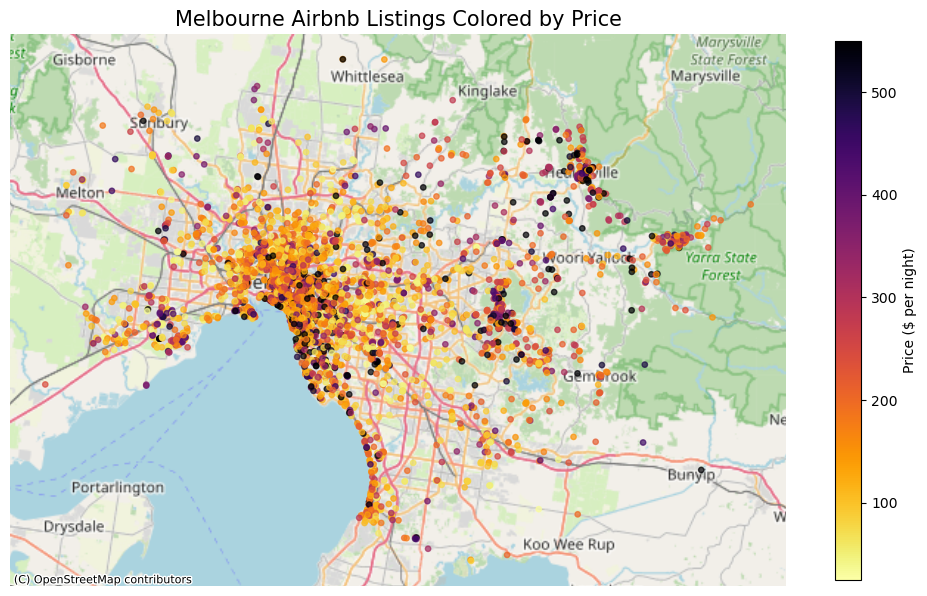

In [9]:
df_train['price'] = df_train['price'].replace('[\$,]', '', regex=True).astype(float)
# 1. Prepare Data (Ensure price is numeric and drop NaNs)
df_price = df_train.dropna(subset=['price', 'latitude', 'longitude']).copy()

# 2. Create GeoDataFrame
gdf_price = gpd.GeoDataFrame(
    df_price,
    geometry=gpd.points_from_xy(df_price.longitude, df_price.latitude),
    crs="EPSG:4326"
)

# 3. Convert CRS to Web Mercator (for the basemap)
gdf_price = gdf_price.to_crs(epsg=3857)

# 4. Calculate a reasonable upper limit for the color scale (e.g., 95th percentile)
# This prevents one $8000/night mansion from making all other points look the same color.
vmax_val = gdf_price['price'].quantile(0.95)

# 5. Plot
fig, ax = plt.subplots(figsize=(10, 8))

gdf_price.plot(
    ax=ax,
    column="price",          # Color by Price
    cmap="inferno_r",        # 'inferno_r' goes from Light (cheap) to Dark/Purple (expensive)
    legend=True,             # Add the colorbar
    legend_kwds={'label': "Price ($ per night)", 'shrink': 0.7},
    markersize=15,
    alpha=0.7,
    vmax=vmax_val            # Cap the color scale at 95th percentile
)

# Add Basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_title("Melbourne Airbnb Listings Colored by Price", fontsize=15)
ax.axis("off")
plt.tight_layout()
plt.show()



The map visualises the spatial distribution of Airbnb listings, colored by nightly price (capped at the 95th percentile to highlight trends). Several distinct pricing clusters emerge, validating the importance of location-based features in the predictive model:

**1. The Coastal Premium (Bayside High-Value Zone)**
A clear cluster of dark purple and black points (representing the highest price tier, >$400/night) runs along the southeastern coastline of Port Phillip Bay. This corresponds to affluent suburbs like **Brighton, St Kilda, and Elwood**. This confirms that proximity to the beach is a major driver of price, distinct from proximity to the city center.

**2. CBD Density vs. Price Variation**
The Central Business District (CBD) exhibits the highest density of listings (the solid cluster in the center). However, the coloring here is mixed—a blend of orange (mid-range) and purple. This reflects the high volume of smaller apartments/studios which, while centrally located, do not command the same premium as large coastal mansions.

**3. The "Hinterland" Effect (Eastern Ranges)**
To the far right of the map (East/Northeast), there is a scattered but noticeable presence of high-priced listings (dark dots) in low-density areas. These correspond to the **Dandenong Ranges and Yarra Valley** regions. These are likely "destination" properties (e.g., entire cabins, wineries, retreats) where isolation and scenery drive the price up, opposing the general trend that "further out = cheaper."


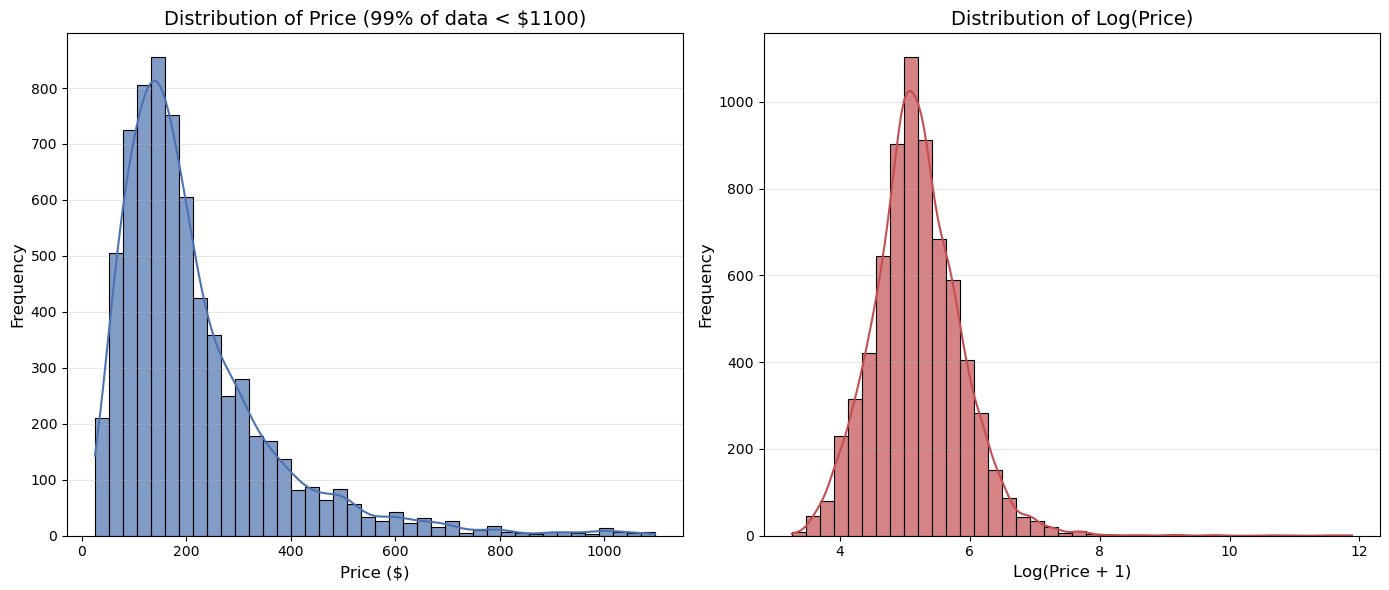

In [15]:
# Prepare data (drop NaNs just in case)
prices = df_train['price'].dropna()

# Create a figure with two subplots
plt.figure(figsize=(14, 6))

# --- Plot 1: Raw Price Distribution (Capped) ---
# We filter out the top 1% of expensive outliers just for the visualization
# otherwise the chart would look like a single skinny bar.
upper_limit = prices.quantile(0.99)
data_capped = prices[prices < upper_limit]

plt.subplot(1, 2, 1)
sns.histplot(data_capped, bins=40, kde=True, color='#4c72b0', edgecolor='black', alpha=0.7)
plt.title(f'Distribution of Price (99% of data < ${upper_limit:.0f})', fontsize=14)
plt.xlabel('Price ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', alpha=0.3)

# --- Plot 2: Log-Transformed Price ---
# This visualizes what the model actually "sees" after log-transformation
plt.subplot(1, 2, 2)
sns.histplot(np.log1p(prices), bins=40, kde=True, color='#c44e52', edgecolor='black', alpha=0.7)
plt.title('Distribution of Log(Price)', fontsize=14)
plt.xlabel('Log(Price + 1)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

The side-by-side comparison of the target variable (`price`) reveals why raw pricing data is unsuitable for direct modeling and necessitates mathematical transformation.

**1. Left Chart: Raw Price Distribution (Extreme Skew)**
The raw price distribution is **highly right-skewed (positive skew)**.
* **The "Long Tail":** The vast majority of listings are clustered between \$50 and \$300, but a long tail extends out to \$1,100+ (and beyond, before capping).
* **The Modeling Problem:** Using this raw distribution would cause models—especially those minimizing squared error—to be heavily biased by high-priced outliers. The model would "over-correct" to try and predict the expensive mansions, ruining its accuracy on the standard apartments that make up 90% of the data.

**2. Right Chart: Log-Transformed Price (Normalization)**
By applying `np.log1p(price)`, the distribution is transformed into a **near-Gaussian (Bell Curve) shape**.
* **Variance Stabilization:** The transformation compresses the range of the target variable. The difference between 100 and 200 becomes mathematically similar to the difference between 1,000 and 2,000 in log-space.
* **The Result:** This "normalizes" the error gradients. It ensures that the model pays equal attention to improving accuracy on budget listings as it does on luxury listings, rather than ignoring the cheap ones to chase the expensive variance.
---
The transition from the skewed distribution (Left) to the symmetrical distribution (Right) confirms that **Log-Transformation was the correct strategy**. It satisfies the normality assumptions of linear models and significantly improves the convergence speed and stability of tree-based models like XGBoost and LightGBM.

/var/folders/44/vfwf3129599809ptfq1qkgrc0000gn/T/ipykernel_31673/3011318089.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_property_types.index, x=top_property_types.values, palette="coolwarm")


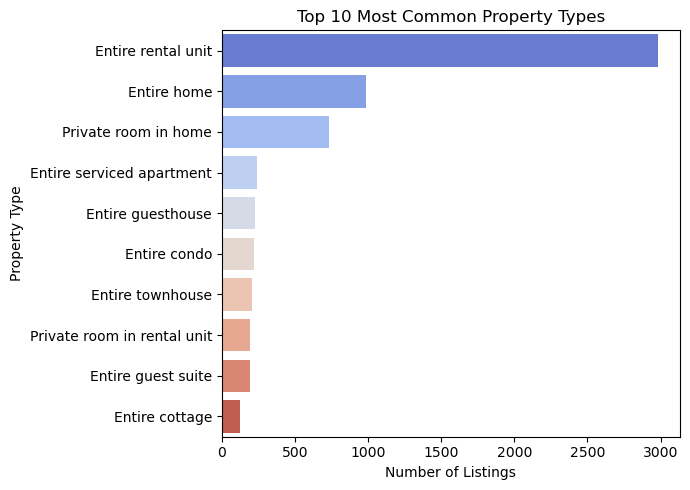

In [10]:
#This insight can guide grouping rare property types into an “other” category during preprocessing 
#and highlights property_type as a useful categorical variable for price prediction.

top_property_types = df_train['property_type'].value_counts().nlargest(10)

plt.figure(figsize=(7, 5))
sns.barplot(y=top_property_types.index, x=top_property_types.values, palette="coolwarm")
plt.title("Top 10 Most Common Property Types")
plt.xlabel("Number of Listings")
plt.ylabel("Property Type")
plt.tight_layout()
plt.show()


The market is overwhelmingly dominated by entire apartments and homes, while unique property types like cottages form a sparse "long tail" distribution. This significant class imbalance validates the decision to use Target Encoding or grouping strategies instead of simple One-Hot Encoding to effectively capture price signals from rare categories without overfitting.

/var/folders/44/vfwf3129599809ptfq1qkgrc0000gn/T/ipykernel_31673/935580218.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_train, x='room_type', y='price', palette="Set2")


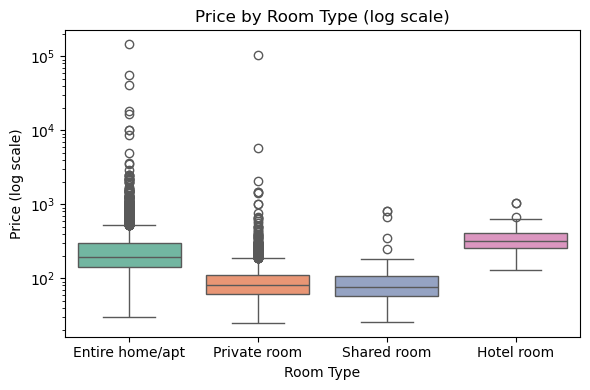

In [11]:
#Key analysis for modeling and suggests the need to log-transform price and handle outliers in data cleaning.

plt.figure(figsize=(6, 4))
sns.boxplot(data=df_train, x='room_type', y='price', palette="Set2")
plt.yscale('log')  # to better visualize outliers
plt.title("Price by Room Type (log scale)")
plt.ylabel("Price (log scale)")
plt.xlabel("Room Type")
plt.tight_layout()
plt.show()



This boxplot illustrates a clear pricing hierarchy where **"Entire home/apt"** listings command the highest median prices and exhibit the greatest variance, including significant high-end outliers. In contrast, **"Private rooms"** and **"Shared rooms"** are clustered at much lower price points with tighter distributions, while the small "Hotel room" category sits in a premium range but lacks the extreme outliers seen in entire homes.